This is a simple demo for calculating the empirical MMD(Maximum Mean Discrepancy) distance between two distribution with some samples. There are two examples: (1) two different univariate gaussian distributions and (2) two subsets of the MNIST dataset.

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [2]:
# In this case we use Gaussian kernel.
def pairwise_kernel(X, Y):
    X = np.expand_dims(X.reshape(X.shape[0], -1), 1).repeat(Y.shape[0], 1)
    Y = np.expand_dims(Y.reshape(Y.shape[0], -1), 0).repeat(X.shape[0], 0)
    l2_distance = ((X - Y) ** 2.).mean(-1)
    gram = np.exp(-l2_distance)
    return gram.mean()

def calc_mmd(X, Y):
    x_kernel = pairwise_kernel(X, X)
    y_kernel = pairwise_kernel(Y, Y)
    xy_kernel = pairwise_kernel(X, Y)
    return x_kernel + y_kernel - 2 * xy_kernel

# This is an empirical estimation of the function f which maximizes Ef(x) - E(f)y.
# Only implement the univariate case here.
def f_evaluation(X, Y, t):
    X, Y = X.reshape(X.shape[0], -1), Y.reshape(Y.shape[0], -1)
    assert X.shape[1] == 1 and Y.shape[1] == 1
    T = np.array(((t))).repeat(X.shape[0], 0)
    x_kernel = np.exp(-((X - T) ** 2.).mean(-1)).mean()
    y_kernel = np.exp(-((Y - T) ** 2.).mean(-1)).mean()
    return x_kernel - y_kernel

Here we calculate the MMD distance between two gaussians along with the probability density and the function f.

In [3]:
def get_data(n, mu_0, sigma_0, mu_1, sigma_1):
    X = np.random.randn(n) * sigma_0 + mu_0
    Y = np.random.randn(n) * sigma_1 + mu_1
    return X, Y

def calc_gauss(X, mu, sigma):
    # 2.50663 = sqrt(2 pi)
    return np.exp(-(X - mu) ** 2. / (2 * (sigma ** 2.))) / (sigma * 2.50663)

def one_round(mu_0, sigma_0, mu_1, sigma_1):
    X, Y = get_data(1000,  mu_0, sigma_0, mu_1, sigma_1)
    
    mmd = calc_mmd(X, Y)
    print(mmd)
    
    plt_t = np.arange(-4, 6, 0.2)
    plt_f = np.array([f_evaluation(X, Y, t) for t in plt_t])
    plt_x = calc_gauss(plt_t, mu_0, sigma_0)
    plt_y = calc_gauss(plt_t, mu_1, sigma_1)
    plt.plot(plt_t, plt_f, color='b', label='f')
    plt.plot(plt_t, plt_x, color='r', label='distribution p')
    plt.plot(plt_t, plt_y, color='g', label='distribution q')
    plt.legend()
    plt.show()

0.25520015140356894


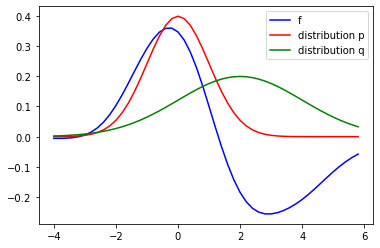

0.25589421026908993


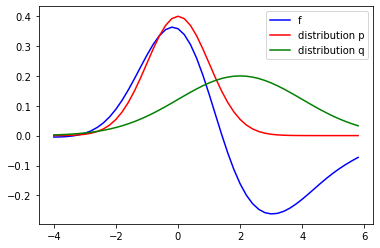

0.00032100397297107897


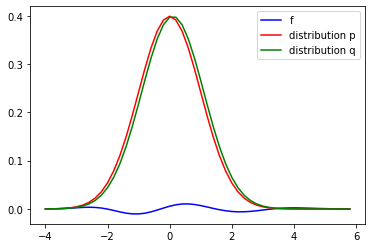

0.002411525230547329


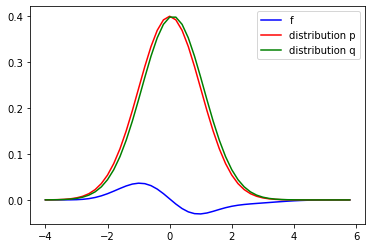

0.0011255361053094104


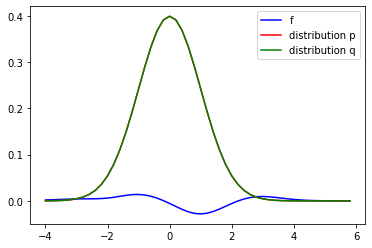

In [4]:
one_round(0, 1, 2, 2)
one_round(0, 1, 2, 2)
one_round(0, 1, 0.1, 1)
one_round(0, 1, 0.1, 1)
one_round(0, 1, 0, 1)

In [5]:
def get_mnist_data():
    transform = transforms.ToTensor()
    mnist_set = datasets.MNIST('.', transform=transform, download=True)

    data = {i:[] for i in range(10)}
    for x, y in mnist_set:
        data[y].append(x)
    for i in range(10):
        data[i] = torch.stack(data[i]).numpy()
    return data

def get_class_data(data, idx):
    data_class = data[idx[0]]
    for i in idx[1:]:
        data_class = np.concatenate([data_class, data[i]])
    return data_class

def calc_class_mmd(data, idx_x, idx_y, batch_size=64):
    # idx_x and idx_y should have the same length
    data_x, data_y = get_class_data(data, idx_x), get_class_data(data, idx_y)
    np.random.shuffle(data_x), np.random.shuffle(data_y)
    
    mmd = []
    len_ = (min(data_x.shape[0], data_y.shape[0]) // batch_size) * batch_size
    for i in range(0, len_, batch_size):
        mmd.append(calc_mmd(data_x[i:i+batch_size], data_y[i:i+batch_size]))
    
    mmd = np.array(mmd).mean()
    return mmd

In [6]:
data = get_mnist_data()
print(calc_class_mmd(data, [0], [0]))
print(calc_class_mmd(data, [0], [1]))
print(calc_class_mmd(data, [0, 1, 2, 3, 4], [0, 1, 2, 3, 5]))
print(calc_class_mmd(data, [0, 1, 2, 3, 4], [5, 6, 7, 8, 9]))

0.0
0.1322385409603948
0.005315523491796668
0.011747084931350741
